In [43]:
import matplotlib.pyplot as plt
import numpy as np

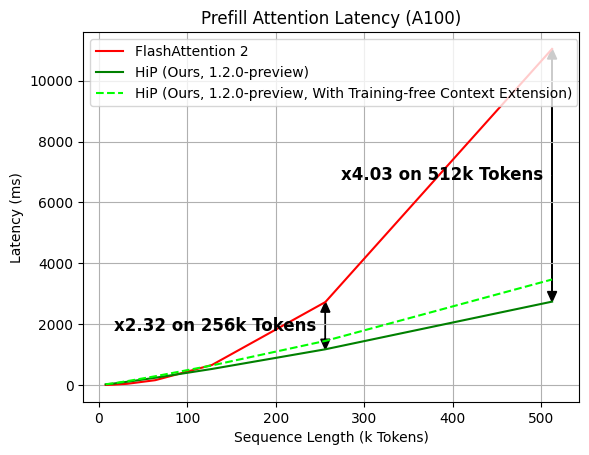

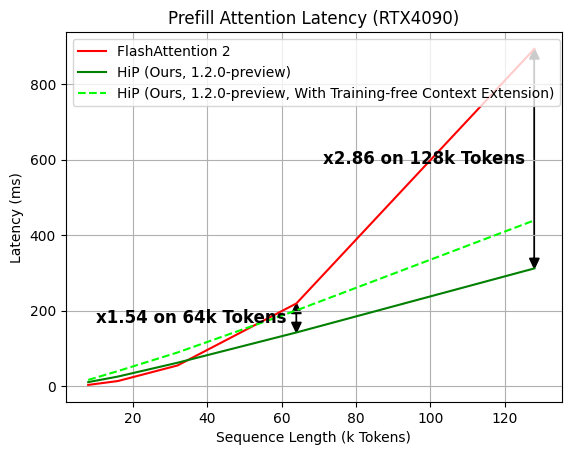

In [34]:
# latency plot

names = {
    'ts': 'T',
    'fa2': 'FlashAttention 2',
    'hip': 'HiP (Ours, 1.2.0-preview)',
    'hip_extend': 'HiP (Ours, 1.2.0-preview, With Training-free Context Extension)'
}

data_a100 = {
    'ts': [8, 16, 32, 64, 128, 256, 512],
    'fa2': [2.700, 9.858, 38.736, 158.696, 658.991, 2725.286, 11043.196],
    'hip': [22.158, 44.376, 104.755, 238.208, 527.548, 1173.765, 2739.473],
    'hip_extend': [25.884, 52.491, 125.614, 288.019, 643.121, 1449.087, 3467.770],
}

data_4090 = {
    'ts': [8, 16, 32, 64, 128],
    'fa2': [3.675, 13.993, 55.111, 219.430, 893.360],
    'hip': [11.106, 25.823, 62.387, 142.583, 312.184],
    'hip_extend': [16.926, 40.349, 89.464, 201.032, 439.410],
}

def render(data, device):
    plt.clf()

    ts = data['ts']
    fa2 = data['fa2']
    hip = data['hip']
    hip_extend = data['hip_extend']

    plt.plot(ts, fa2, color='red', label=names['fa2'])
    plt.plot(ts, hip, color='green', label=names['hip'])
    plt.plot(ts, hip_extend, color='lime', linestyle='--', label=names['hip_extend'])

    def arrow(start_x, start_y, end_x, end_y):
        cx = (start_x + end_x) / 2
        cy = (start_y + end_y) / 2
        plt.arrow(
            cx, cy, start_x-cx, start_y-cy, 
            head_length = max(fa2) * 0.03, head_width = max(ts) * 0.02, 
            length_includes_head = True, color='black'
        )
        plt.arrow(
            cx, cy, -start_x+cx, -start_y+cy, 
            head_length = max(fa2) * 0.03, head_width = max(ts) * 0.02, 
            length_includes_head = True, color='black'
        )

    def diff(idx):
        arrow(ts[idx], fa2[idx], ts[idx], hip[idx])
        plt.annotate(
            f'x{fa2[idx] / hip[idx]:.2f} on {ts[idx]}k Tokens', 
            (ts[idx] - max(ts) * 0.02, (hip[idx] + fa2[idx]) / 2), 
            fontsize=12, ha='right', va='center', fontweight=900,
        )
    diff(-1)
    diff(-2)

    plt.grid()
    plt.legend(loc='upper left')
    plt.xlabel('Sequence Length (k Tokens)')
    plt.ylabel('Latency (ms)')
    plt.title(f'Prefill Attention Latency ({device})')

    plt.show()

render(data_a100, 'A100')
render(data_4090, 'RTX4090')

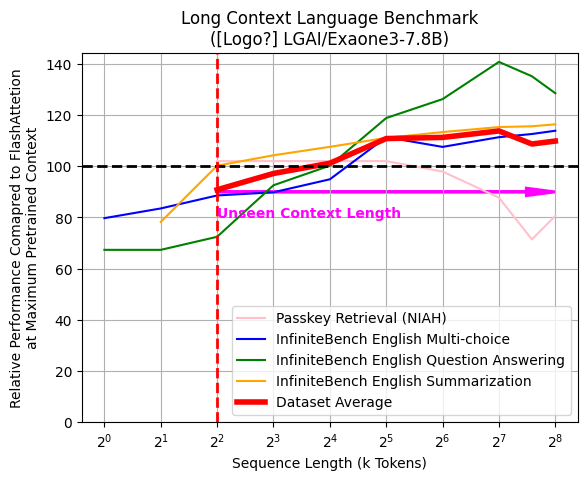

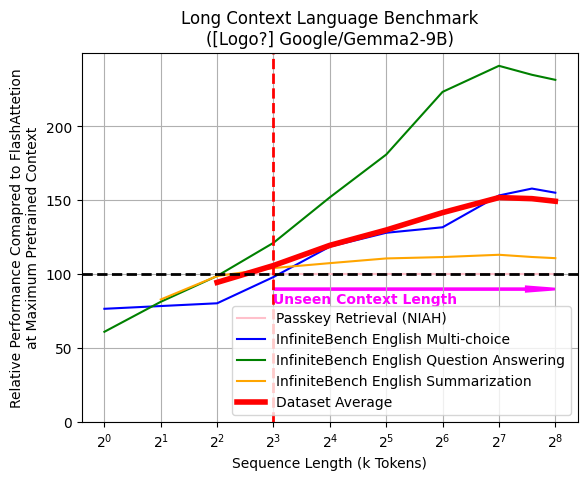

In [76]:
# long context QA benchmark

names = {
    'passkey': 'Passkey Retrieval (NIAH)',
    'en_mc': 'InfiniteBench English Multi-choice',
    'en_qa': 'InfiniteBench English Question Answering',
    'en_sum': 'InfiniteBench English Summarization',
    'average': 'Dataset Average'
}

colors = {
    'passkey': 'pink',
    'en_mc': 'blue', 
    'en_qa': 'green',
    'en_sum': 'orange',
    'average': 'red',
}

data_exone = {
    'ts': [1, 2, 4, 8, 16, 32, 64, 128, 192, 256],
    'passkey': [None, None, 100.0000, 100.0000, 100.0000, 100.0000, 96.0000, 86.0000, 70.0000, 79.0000],
    'passkey_fa2': 98.0,
    'en_mc': [0.2751, 0.2882, 0.3057, 0.3100, 0.3275, 0.3843, 0.3712, 0.3843, 0.3886, 0.3930],
    'en_mc_fa2': 0.3450,
    'en_qa': [0.0264, 0.0264, 0.0284, 0.0363, 0.0393, 0.0466, 0.0495, 0.0552, 0.0530, 0.0504],
    'en_qa_fa2': 0.0392,
    'en_sum': [None, 0.1830, 0.2344, 0.2439, 0.2516, 0.2598, 0.2651, 0.2697, 0.2704, 0.2722],
    'en_sum_fa2': 0.2338,
}

data_gemma = {
    'ts': [1, 2, 4, 8, 16, 32, 64, 128, 192, 256],
    'passkey': [None, None, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000],
    'passkey_fa2': 100.0,
    'en_mc': [0.3581, 0.3668, 0.3755, 0.4585, 0.5546, 0.5983, 0.6157, 0.7162, 0.7380, 0.7249],
    'en_mc_fa2': 0.4672,
    'en_qa': [0.0735, 0.0979, 0.1189, 0.1459, 0.1829, 0.2177, 0.2687, 0.2899, 0.2826, 0.2785],
    'en_qa_fa2': 0.1203,
    'en_sum': [None, 0.1774, 0.2113, 0.2229, 0.2300,  0.2368, 0.2388, 0.2421, 0.2389, 0.2372],
    'en_sum_fa2': 0.2139,
}

def render(data, model, max_trained):
    plt.clf()

    yss = []
    ts = data['ts']
    def proc_subset(key):
        fa2 = data[key+'_fa2']
        ys = data[key]
        ys = list(map(lambda x: (x / fa2 * 100 if x is not None else None), ys))
        yss.append(ys)
        plt.plot(ts, ys, label=names[key], color=colors[key])
    
    proc_subset('passkey')
    proc_subset('en_mc')
    proc_subset('en_qa')
    proc_subset('en_sum')

    yss = np.array(yss, dtype=np.float32)
    ys = np.mean(yss, axis=0)
    plt.plot(ts, ys.tolist(), label=names['average'], color=colors['average'], linewidth=4)

    plt.axhline(100, linestyle='--', linewidth=2, color='black')
    plt.axvline(max_trained, linestyle='--', linewidth=2, color='red')

    plt.arrow(
        max_trained, 90, 256 - max_trained, 0, 
        linewidth=2, color='magenta',
        head_length = max(ts) * 0.3, head_width = 150 * 0.02, 
        length_includes_head = True
    )
    plt.annotate('Unseen Context Length', (max_trained, 80), fontweight=900, color='magenta')

    plt.legend()
    plt.grid()
    plt.title(f'Long Context Language Benchmark\n({model})')
    plt.xlabel('Sequence Length (k Tokens)')
    plt.ylabel('Relative Performance Comapred to FlashAttetion\nat Maximum Pretrained Context')
    plt.ylim(0, None)
    plt.xscale('log', base=2)

    plt.show()

render(data_exone, '[Logo?] LGAI/Exaone3-7.8B', 4)
render(data_gemma, '[Logo?] Google/Gemma2-9B', 8)

In [ ]:
# long context RAG benchmark